In [ ]:
import pandas as pd
import numpy as np
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Bidirectional
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



In [ ]:
data = pd.read_csv('Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#Data Preprocessing and EDA
Converting and separating rating based on scores into 3 classes: Negative, Neutral, Positive

In [ ]:
# Remove duplicates and nulls
df = data.drop_duplicates(subset=["UserId", "ProfileName", "Text"])
df = df.dropna(subset=["Text", "Score"])
# Convert score to sentiment
def score_to_sentiment(score):
    if score <= 2:
        return "negative"
    elif score == 3:
        return "neutral"
    else:
        return "positive"

df["Sentiment"] = df["Score"].apply(score_to_sentiment)

# Clean review text
stop_words = set(ENGLISH_STOP_WORDS)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return " ".join(words)

df["Clean_Text"] = df["Text"].apply(clean_text)

# Adding review length column
df["Review_Length"] = df["Clean_Text"].apply(lambda x: len(x.split()))


In [ ]:
df[["Text", "Clean_Text", "Sentiment", "Review_Length"]].head(100)


,Text,Clean_Text,Sentiment,Review_Length
0,I have bought several of the Vitality canned d...,bought vitality canned dog food products good ...,positive,21
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,negative,18
2,This is a confection that has been around a fe...,confection centuries light pillowy citrus gela...,positive,38
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe g...,negative,16
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,positive,13
...,...,...,...,...
96,My 1-1/2 year old basenji/jack russell mix lov...,year old basenjijack russell mix loves dog foo...,positive,80
97,Our pup has experienced allergies in forms of ...,pup experienced allergies forms hotspots itchi...,positive,29
98,My English Bulldog had skin allergies the summ...,english bulldog skin allergies summer got age ...,positive,36
99,I fed this to my Golden Retriever and he hated...,fed golden retriever hated wouldnt eat did gav...,negative,13


#EDA

 Plot 1: Sentiment Distribution


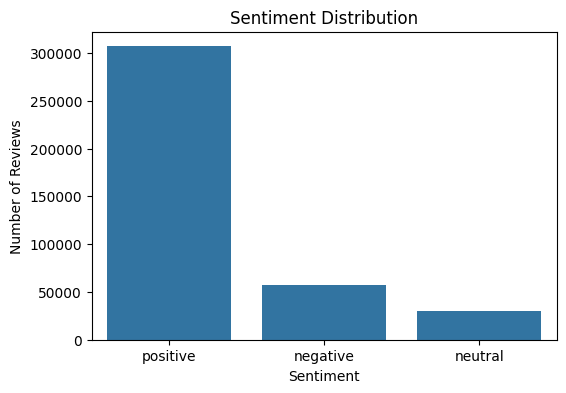

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Sentiment", data=df)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

Plot 2: Word Clouds for each sentiment


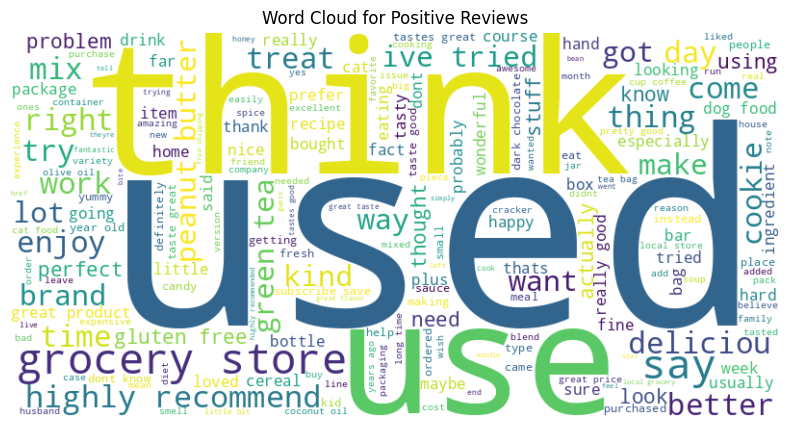

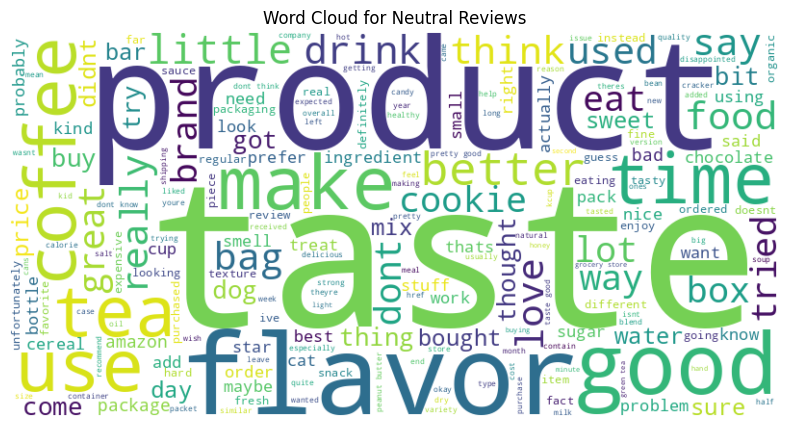

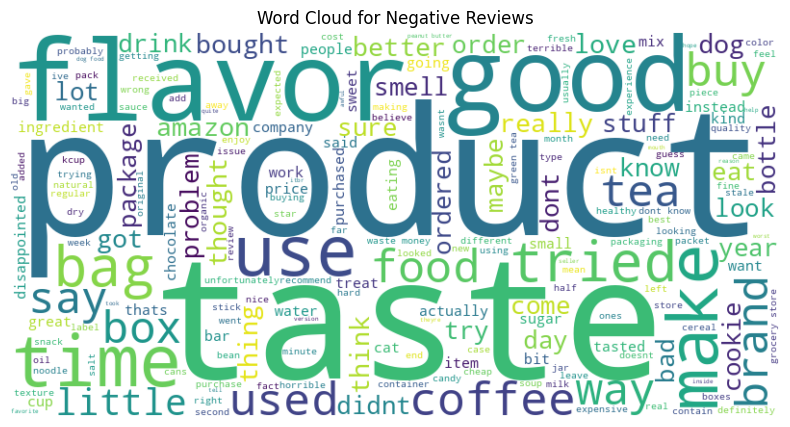

In [ ]:
for sentiment in ["positive", "neutral", "negative"]:
    text = " ".join(df[df["Sentiment"] == sentiment]["Clean_Text"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment.capitalize()} Reviews")
    plt.show()


Plot 3: Review length distribution


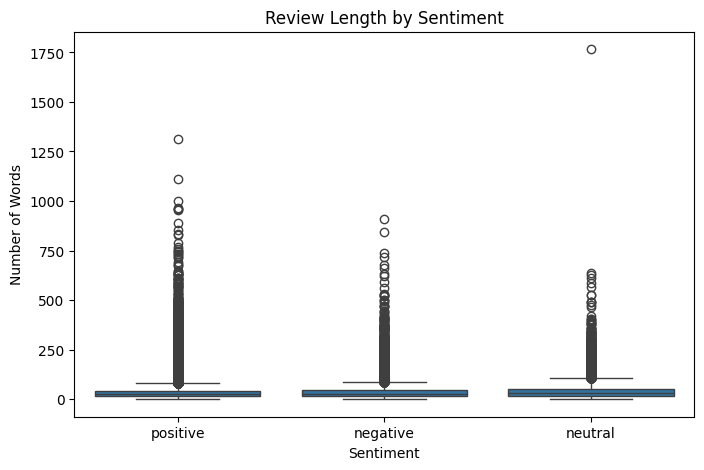

In [ ]:
df["Review_Length"] = df["Clean_Text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Sentiment", y="Review_Length")
plt.title("Review Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()

## Trying out multiple models to compare performance on TF-IDF Vectors:



###1. Logistic Regression with TF-IDF

In [ ]:
#Splitting data into train test split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(df["Clean_Text"], df["Sentiment"], test_size=0.2, random_state=42)

#tf-idf vectors
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf_lr = tfidf.fit_transform(X_train_lr)
X_test_tfidf_lr = tfidf.transform(X_test_lr)

#logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf_lr, y_train_lr)

y_pred_lr = model.predict(X_test_tfidf_lr)

# Metrics
acc = accuracy_score(y_test_lr, y_pred_lr)
f1 = f1_score(y_test_lr, y_pred_lr, average='weighted')

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print("\n Classification Report:")
print(classification_report(y_test_lr, y_pred_lr))
print("\n Confusion Matrix:")
print(confusion_matrix(y_test_lr, y_pred_lr))



Test Accuracy: 0.8604
Test F1 Score: 0.8403

 Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.65      0.69     11514
     neutral       0.45      0.14      0.21      5808
    positive       0.89      0.97      0.93     61408

    accuracy                           0.86     78730
   macro avg       0.69      0.59      0.61     78730
weighted avg       0.84      0.86      0.84     78730


 Confusion Matrix:
[[ 7530   425  3559]
 [ 1344   808  3656]
 [ 1467   543 59398]]


###2. CNNs with TF-IDF

In [ ]:
# Keeping only relevant columns
df = df[['Text', 'Score']]
df = df.dropna(subset=['Text', 'Score'])
def map_sentiment(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['Sentiment'] = df['Score'].apply(map_sentiment)
df = df.rename(columns={'Text': 'Clean_Text'})

#Tokenize
vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["Clean_Text"])
sequences = tokenizer.texts_to_sequences(df["Clean_Text"])
padded = pad_sequences(sequences, maxlen=max_len)

# One-hot encoding
y_cnn = to_categorical(df['Sentiment'], num_classes=3)

# Train-test split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(padded, y_cnn, test_size=0.2, random_state=42)

In [ ]:
#model training
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3-class output
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_cnn, y_train_cnn,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.8311 - loss: 0.4658 - val_accuracy: 0.8766 - val_loss: 0.3448
Epoch 2/5
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.8800 - loss: 0.3252 - val_accuracy: 0.8795 - val_loss: 0.3233
Epoch 3/5
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8917 - loss: 0.2863 - val_accuracy: 0.8774 - val_loss: 0.3278
Epoch 4/5
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9017 - loss: 0.2587 - val_accuracy: 0.8783 - val_loss: 0.3317
Epoch 5/5
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9101 - loss: 0.2365 - val_accuracy: 0.8780 - val_loss: 0.3352


In [ ]:
#predict
y_pred_prob_cnn = model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_prob_cnn, axis=1)
y_true_cnn = np.argmax(y_test_cnn, axis=1)

#metrics
print(f"\n Test Accuracy: {model.evaluate(X_test_cnn, y_test_cnn, verbose=0)[1]:.4f}")
print("\n Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=['Negative', 'Neutral', 'Positive']))
print("\n Confusion Matrix:")
print(confusion_matrix(y_true_cnn, y_pred_cnn))

2461/2461 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

 Test Accuracy: 0.8772

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.73      0.74     11514
     Neutral       0.49      0.24      0.32      5808
    Positive       0.92      0.97      0.94     61408

    accuracy                           0.88     78730
   macro avg       0.72      0.64      0.67     78730
weighted avg       0.86      0.88      0.87     78730


 Confusion Matrix:
[[ 8364   718  2432]
 [ 1493  1398  2917]
 [ 1382   725 59301]]


### 3. SVC with TF-IDF

In [ ]:
#Splitting data into train test split
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(df["Clean_Text"], df["Sentiment"], test_size=0.2, random_state=42)

#tf-idf vectors
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf_svc = tfidf.fit_transform(X_train_svc)
X_test_tfidf_svc = tfidf.transform(X_test_svc)
svc = LinearSVC(C=1, class_weight=None, max_iter=2000)
svc.fit(X_train_tfidf_svc, y_train_svc)
y_pred_svc = svc.predict(X_test_tfidf_svc)

#metrics
acc = accuracy_score(y_test_svc, y_pred_svc)
f1 = f1_score(y_test_svc, y_pred_svc, average='weighted')

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print("\n Classification Report:")
print(classification_report(y_test_svc, y_pred_svc))
print("\n Confusion Matrix:")
print(confusion_matrix(y_test_svc, y_pred_svc))

Test Accuracy: 0.8671
Test F1 Score: 0.8466

 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71     11514
           1       0.51      0.13      0.21      5808
           2       0.90      0.97      0.93     61408

    accuracy                           0.87     78730
   macro avg       0.71      0.60      0.62     78730
weighted avg       0.84      0.87      0.85     78730


 Confusion Matrix:
[[ 7967   323  3224]
 [ 1528   765  3515]
 [ 1453   418 59537]]


## Testing on manual reviews

In [ ]:
# Mapping prediction index to label
label_map = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

def predict_review_sentiment(review_text):
    # Step 1: Tokenize + pad the input
    sequence = tokenizer.texts_to_sequences([review_text])
    padded_input = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded_input)
    predicted_class = prediction.argmax(axis=1)[0]
    print(f"\n Review: {review_text}")
    print(f"Predicted Sentiment: {label_map[predicted_class]} ({predicted_class})")

# Testing Examples
predict_review_sentiment("This product was excellent and delivery was super fast!")
predict_review_sentiment("It was okay, nothing special.")
predict_review_sentiment("Worst experience ever. Wouldn't recommend.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step

 Review: This product was excellent and delivery was super fast!
Predicted Sentiment: Positive (2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 Review: It was okay, nothing special.
Predicted Sentiment: Neutral (1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

 Review: Worst experience ever. Wouldn't recommend.
Predicted Sentiment: Negative (0)


#Comparison of metrics

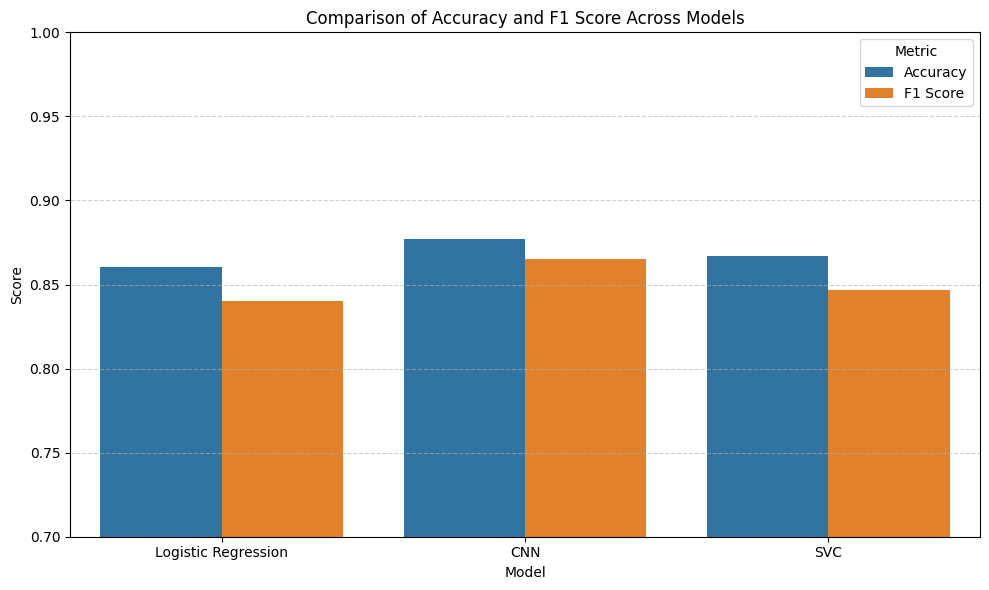

In [ ]:
acc_lr = accuracy_score(y_test_lr, y_pred_lr)
f1_lr = f1_score(y_test_lr, y_pred_lr, average='weighted')

acc_cnn = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)[1]
f1_cnn = f1_score(y_true_cnn, y_pred_cnn, average='weighted')

acc_svc = accuracy_score(y_test_svc, y_pred_svc)
f1_svc = f1_score(y_test_svc, y_pred_svc, average='weighted')

metrics_data = {
    'Model': ['Logistic Regression', 'CNN', 'SVC'],
    'Accuracy': [acc_lr, acc_cnn, acc_svc],
    'F1 Score': [f1_lr, f1_cnn, f1_svc]
}


df_metrics = pd.DataFrame(metrics_data)
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')


plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')
plt.title('Comparison of Accuracy and F1 Score Across Models')
plt.ylim(0.7, 1.0)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Training algorithms on GloVe based sentence embeddings

In [ ]:
df = pd.read_csv("Reviews.csv")
df = df[['Text', 'Score']].dropna()
df['Sentiment'] = df['Score'].apply(lambda s: 0 if s <= 2 else (1 if s == 3 else 2))
df = df.rename(columns={'Text': 'Clean_Text'})

# Tokenization
vocab_size = 10000
max_len = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Clean_Text'])
sequences = tokenizer.texts_to_sequences(df['Clean_Text'])
padded = pad_sequences(sequences, maxlen=max_len)
word_index = tokenizer.word_index

# CBOW: Load GloVe embeddings
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


### 1. Logistic Regression

In [ ]:
#logistic regression
def sentence_to_vector(sentence):
    words = sentence.lower().split()
    vectors = [embedding_index[word] for word in words if word in embedding_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

# Convert text to vectors
X_vec = np.vstack([sentence_to_vector(text) for text in tqdm(df["Clean_Text"])])
y = df["Sentiment"]

# Train/test split
X_train_glr, X_test_glr, y_train_glr, y_test_glr = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_glr, y_train_glr)
y_pred_glr = lr.predict(X_test_glr)

# Metrics
print(f"\n Accuracy: {accuracy_score(y_test_glr, y_pred_glr):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_test_glr, y_pred_glr, average='weighted'):.4f}")
print(f"F1 Score (Macro): {f1_score(y_test_glr, y_pred_glr, average='macro'):.4f}")
print("\n Classification Report:")
print(classification_report(y_test_glr, y_pred_glr, target_names=["Negative", "Neutral", "Positive"]))

100%|██████████| 568454/568454 [00:53<00:00, 10553.88it/s]



 Accuracy: 0.8018
F1 Score (Weighted): 0.7542
F1 Score (Macro): 0.4346

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.56      0.30      0.39     16181
     Neutral       0.31      0.01      0.02      8485
    Positive       0.82      0.97      0.89     89025

    accuracy                           0.80    113691
   macro avg       0.56      0.43      0.43    113691
weighted avg       0.75      0.80      0.75    113691



### 2. SVC

In [ ]:
#SVC
def sentence_to_vector(sentence):
    words = sentence.lower().split()
    vectors = [embedding_index[word] for word in words if word in embedding_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

# text to sentence vector
X_vec = np.vstack([sentence_to_vector(text) for text in tqdm(df["Clean_Text"])])
y = df["Sentiment"]


X_train_gsvc, X_test_gsvc, y_train_gsvc, y_test_gsvc = train_test_split(X_vec, y, test_size=0.2, random_state=42)


svc_model = LinearSVC(max_iter=2000)
svc_model.fit(X_train_gsvc, y_train_gsvc)

y_pred_gsvc = svc_model.predict(X_test_gsvc)

# metric
print("Accuracy:", accuracy_score(y_test_gsvc, y_pred_gsvc))
print(f"F1 Score (Weighted): {f1_score(y_test_gsvc, y_pred_gsvc, average='weighted'):.4f}")
print(f"F1 Score (Macro): {f1_score(y_test_gsvc, y_pred_gsvc, average='macro'):.4f}")
print("\nClassification Report:\n", classification_report(y_test_svc, y_pred_svc))


100%|██████████| 568454/568454 [00:55<00:00, 10320.19it/s]


Accuracy: 0.8005295054137971
F1 Score (Weighted): 0.7440
F1 Score (Macro): 0.4085

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71     11514
           1       0.51      0.13      0.21      5808
           2       0.90      0.97      0.93     61408

    accuracy                           0.87     78730
   macro avg       0.71      0.60      0.62     78730
weighted avg       0.84      0.87      0.85     78730



3. CNN

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Labels
y = to_categorical(df['Sentiment'], num_classes=3)
X_train_gcnn, X_test_gcnn, y_train_gcnn, y_test_gcnn = train_test_split(padded, y, test_size=0.2, random_state=42)

# CNN model using pretrained GloVe embeddings
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=True),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_gcnn, y_train_gcnn,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

y_pred_prob_gcnn = model.predict(X_test_gcnn)
y_pred_gcnn = np.argmax(y_pred_prob_gcnn, axis=1)
y_true_gcnn = np.argmax(y_test_gcnn, axis=1)
f1_weighted = f1_score(y_true_gcnn, y_pred_gcnn, average='weighted')
f1_macro = f1_score(y_true_gcnn, y_pred_gcnn, average='macro')

#metrics
print(f"\n Accuracy: {model.evaluate(X_test_gcnn, y_test_gcnn, verbose=0)[1]:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print("\n Classification Report:")
print(classification_report(y_true_gcnn, y_pred_gcnn, target_names=['Negative', 'Neutral', 'Positive']))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8260 - loss: 0.4923 - val_accuracy: 0.8781 - val_loss: 0.3456
Epoch 2/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8771 - loss: 0.3314 - val_accuracy: 0.8910 - val_loss: 0.3000
Epoch 3/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8909 - loss: 0.2955 - val_accuracy: 0.8978 - val_loss: 0.2910
Epoch 4/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9007 - loss: 0.2692 - val_accuracy: 0.9008 - val_loss: 0.2748
Epoch 5/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.9084 - loss: 0.2479 - val_accuracy: 0.9033 - val_loss: 0.2702
Epoch 6/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9154 - loss: 0.2309 - val_accuracy: 0.9065 - val_loss: 0.2639
Epoch 7/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.9210 - loss: 0.2151 - val_accuracy: 0.9090 - val_loss: 0.2591
Epoch 8/10
5685/5685 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9270 - loss: 0

# Comparision of metrics

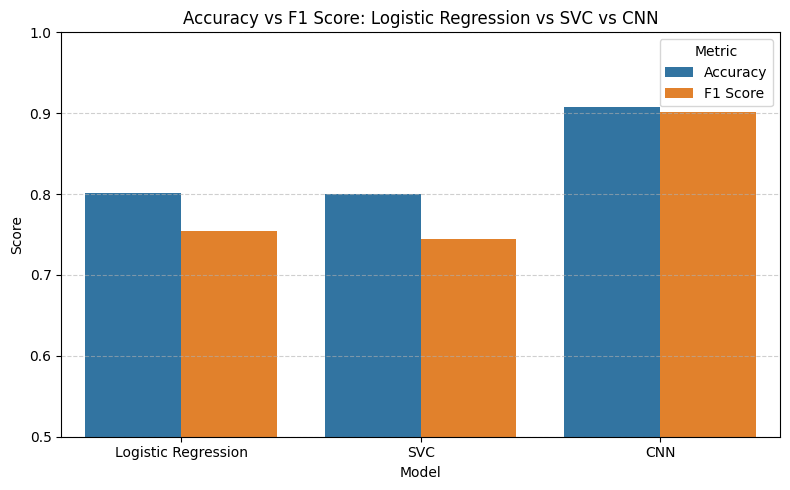

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

acc_lr = accuracy_score(y_test_glr, y_pred_glr)
f1_lr = f1_score(y_test_glr, y_pred_glr, average='weighted')

acc_svc = accuracy_score(y_test_gsvc, y_pred_gsvc)
f1_svc = f1_score(y_test_gsvc, y_pred_gsvc, average='weighted')

acc_cnn = model.evaluate(X_test_gcnn, y_test_gcnn, verbose=0)[1]
f1_cnn = f1_score(y_true_gcnn, y_pred_gcnn, average='weighted')

metrics_data = {
    'Model': ['Logistic Regression', 'SVC', 'CNN'],
    'Accuracy': [acc_lr, acc_svc, acc_cnn],
    'F1 Score': [f1_lr, f1_svc, f1_cnn]
}

df_metrics = pd.DataFrame(metrics_data)
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')


plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')
plt.title('Accuracy vs F1 Score: Logistic Regression vs SVC vs CNN')
plt.ylim(0.5, 1.0)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Training CNN algorithm on BERT based sentence transformer

In [ ]:
df = pd.read_csv('Reviews.csv', usecols=['Text', 'Score'])
df.dropna(inplace=True)
#cleaning text
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_review'] = df['Text'].apply(clean_text)


In [ ]:
from sentence_transformers import SentenceTransformer

def map_sentiment(score):
    if score in [1, 2]:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['sentiment'] = df['Score'].apply(map_sentiment)

#bert model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
batch_size = 10000
embeddings = []

for start in range(0, len(df), batch_size):
    end = min(start + batch_size, len(df))
    batch_sentences = df['clean_review'].iloc[start:end].tolist()
    batch_embeddings = bert_model.encode(batch_sentences, show_progress_bar=True)
    embeddings.append(batch_embeddings)

    del batch_sentences
    gc.collect()

X_embeddings = np.vstack(embeddings)
print("Shape of BERT Embeddings:", X_embeddings.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

Shape of BERT Embeddings: (568454, 384)


In [ ]:
del df['Text']
del df['clean_review']
gc.collect()

y = to_categorical(df['sentiment'], num_classes=3)
del df
gc.collect()


0

In [ ]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)


In [ ]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train_bert.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_bert, y_train_bert, validation_split=0.2, epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11370/11370 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.8197 - loss: 0.4984 - val_accuracy: 0.8344 - val_loss: 0.4487
Epoch 2/10
11370/11370 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.8328 - loss: 0.4571 - val_accuracy: 0.8394 - val_loss: 0.4350
Epoch 3/10
11370/11370 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.8374 - loss: 0.4451 - val_accuracy: 0.8427 - val_loss: 0.4266
Epoch 4/10
11370/11370 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.8407 - loss: 0.4361 - val_accuracy: 0.8453 - val_loss: 0.4180
Epoch 5/10
11370/11370 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.8446 - loss: 0.4241 - val_accuracy: 0.8478 - val_loss: 0.4157
Epoch 6/10
11370/11370 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.8480 - loss: 0.4164 - val_accuracy: 0.8470 - val_loss: 0.4124
Epoch 7/10
11370/11370 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.8495 - loss: 0.4105 - val_accuracy: 0.8513 - val_loss: 0.4066
Epoch 8/10
11370/11370 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 

In [ ]:
loss, accuracy = model.evaluate(X_test_bert, y_test_bert)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


3553/3553 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8546 - loss: 0.4002
Test Loss: 0.3963
Test Accuracy: 0.8555


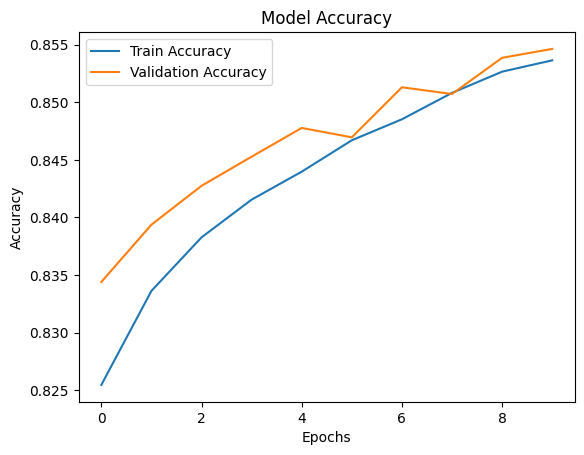

In [ ]:
#data visualization
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



## Cross Validation:
 Classification using BERT embeddings + neural network evaluated with Stratified K-Fold cross-validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

# Load and clean
df = pd.read_csv('Reviews.csv', usecols=['Text', 'Score']).dropna()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_review'] = df['Text'].apply(clean_text)

def map_sentiment(score):
    if score in [1, 2]:
        return 0  # negative
    elif score == 3:
        return 1  # neutral
    else:
        return 2  # positive

df['sentiment'] = df['Score'].apply(map_sentiment)

labels = df['sentiment'].values
X = X_embeddings
y = to_categorical(labels, num_classes=3)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores, acc_scores = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, labels)):
    print(f"\n Fold {fold + 1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    acc = accuracy_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    acc_scores.append(acc)
    f1_scores.append(f1)

print("\n Cross-Validation Results:")
print("Average Accuracy:", np.mean(acc_scores))
print("Average F1 Score:", np.mean(f1_scores))



 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3553/3553 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

 Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Ablation model

In [ ]:
# dataset
df = pd.read_csv('Reviews.csv', usecols=['Text', 'Score'])
df.dropna(inplace=True)

# Ablation 1: Input Dimension Ablation
# Limit to reviews between 5 and 100 words by filtering review length
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
df = df[(df['word_count'] >= 5) & (df['word_count'] <= 100)]

# Ablation 2: Preprocessing variant - with stopword removal and lemmatization
stop_words = set(stopwords.words('english'))

def clean_text(text, remove_stopwords=True, use_lemmatization=False):
    import nltk
    nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer
    from nltk.tokenize import word_tokenize
    lemmatizer = WordNetLemmatizer()

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)

    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]

    if use_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply cleaned text on above ablation settings
df['clean_review'] = df['Text'].apply(lambda x: clean_text(x, remove_stopwords=True, use_lemmatization=False))

def map_sentiment(score):
    if score in [1, 2]:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['sentiment'] = df['Score'].apply(map_sentiment)

# Ablation 3: Pre-trained frozen embeddings
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
batch_size = 10000
embeddings = []

for start in range(0, len(df), batch_size):
    end = min(start + batch_size, len(df))
    batch_sentences = df['clean_review'].iloc[start:end].tolist()
    batch_embeddings = bert_model.encode(batch_sentences, show_progress_bar=True)
    embeddings.append(batch_embeddings)

    del batch_sentences
    gc.collect()

X_embeddings = np.vstack(embeddings)
print("Shape of BERT Embeddings:", X_embeddings.shape)

y = to_categorical(df['sentiment'], num_classes=3)
del df
gc.collect()

X_train_bert_ab, X_test_bert_ab, y_train_bert_ab, y_test_bert_ab = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

# Ablation 4: Reduce Model complexity by reducing size of hidden layers
# Ablation 5: Dropout variation
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_bert_ab.shape[1],)))  # Reduced from 256 to 128 units
model.add(Dropout(0.3))  # Changed dropout from 0.5 to 0.3
model.add(Dense(64, activation='relu'))        # Reduced from 128 to 64 units
model.add(Dropout(0.2))                         # Changed dropout
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_bert_ab, y_train_bert_ab, validation_split=0.2, epochs=10, batch_size=32)

print("\nTest Evaluation:")
y_pred_ab = model.predict(X_test_bert_ab)
print(classification_report(np.argmax(y_test_bert_ab, axis=1), np.argmax(y_pred_ab, axis=1)))


Streaming output truncated to the last 5000 lines.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading packa

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/77 [00:00<?, ?it/s]

Shape of BERT Embeddings: (432434, 384)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8649/8649 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.8369 - loss: 0.4607 - val_accuracy: 0.8492 - val_loss: 0.4161
Epoch 2/10
8649/8649 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.8538 - loss: 0.4068 - val_accuracy: 0.8573 - val_loss: 0.3959
Epoch 3/10
8649/8649 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.8584 - loss: 0.3947 - val_accuracy: 0.8587 - val_loss: 0.3899
Epoch 4/10
8649/8649 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.8626 - loss: 0.3812 - val_accuracy: 0.8605 - val_loss: 0.3908
Epoch 5/10
8649/8649 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.8664 - loss: 0.3730 - val_accuracy: 0.8639 - val_loss: 0.3783
Epoch 6/10
8649/8649 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.8693 - loss: 0.3650 - val_accuracy: 0.8661 - val_loss: 0.3751
Epoch 7/10
8649/8649 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.8721 - loss: 0.3572 - val_accuracy: 0.8663 - val_loss: 0.3741
Epoch 8/10
8649/8649 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.8732 - loss: 0


# Comparision of metrics (Original vs Ablation model)

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
2703/2703 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


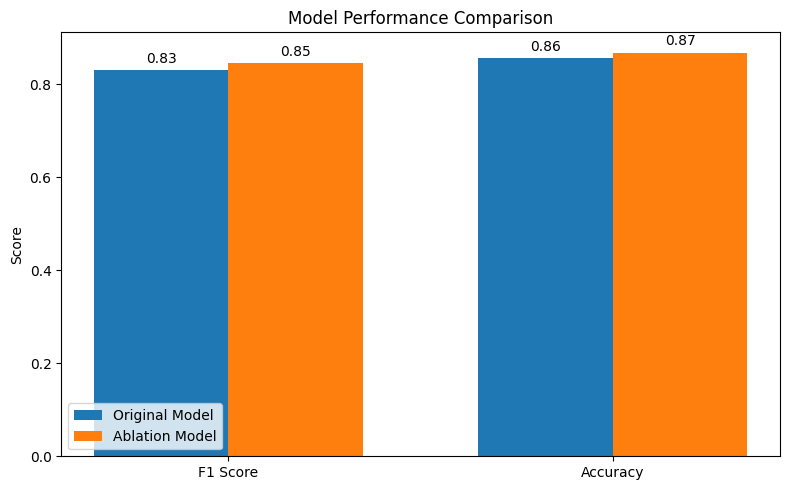

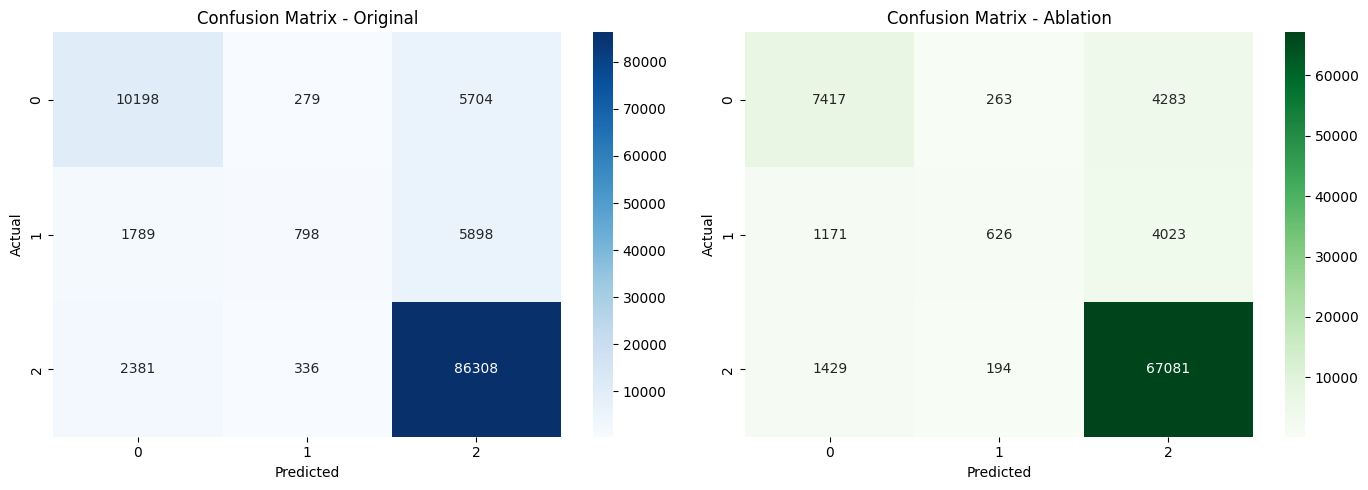

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Original Model
y_true_original = np.argmax(y_test_bert, axis=1)
y_pred_original = np.argmax(model.predict(X_test_bert), axis=1)

# Ablation Model
y_true_ablation = np.argmax(y_test_bert_ab, axis=1)
y_pred_ablation = np.argmax(model.predict(X_test_bert_ab), axis=1)

# Metric Calculation
acc_orig = accuracy_score(y_true_original, y_pred_original)
f1_orig = f1_score(y_true_original, y_pred_original, average='weighted')

acc_ab = accuracy_score(y_true_ablation, y_pred_ablation)
f1_ab = f1_score(y_true_ablation, y_pred_ablation, average='weighted')

metrics = ['F1 Score', 'Accuracy']
original_scores = [f1_orig, acc_orig]
ablation_scores = [f1_ab, acc_ab]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width/2, original_scores, width, label='Original Model')
bar2 = ax.bar(x + width/2, ablation_scores, width, label='Ablation Model')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original
cm_orig = confusion_matrix(y_true_original, y_pred_original)
sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Original')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Ablation
cm_ab = confusion_matrix(y_true_ablation, y_pred_ablation)
sns.heatmap(cm_ab, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Confusion Matrix - Ablation')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()
